# [NILUT: Conditional Neural Implicit 3D Lookup Tables for Image Enhancement](https://arxiv.org/abs/2306.11920)

### Example of Conditional NILUT for Multi-style encoding and Blending.

<img src="media/header.png" alt="NILUT" width="1000"> 

[Paper link here](https://arxiv.org/abs/2306.11920)

> 3D lookup tables (3D LUTs) are a key component for image enhancement. Modern image signal processors (ISPs) have dedicated support for these as part of the camera rendering pipeline. Cameras typically provide multiple options for picture styles, where each style is usually obtained by applying a unique handcrafted 3D LUT. Current approaches for learning and applying 3D LUTs are notably fast, yet not so memory-efficient, as storing multiple 3D LUTs is required. For this reason and other implementation limitations, their use on mobile devices is less popular.
In this work, we propose a Neural Implicit LUT (NILUT), an implicitly defined continuous 3D color transformation parameterized by a neural network. We show that NILUTs are capable of accurately emulating real 3D LUTs. Moreover, a NILUT can be extended to incorporate multiple styles into a single network with the ability to blend styles implicitly. Our novel approach is memory-efficient, controllable and can complement previous methods, including learned ISPs.

Contact marcos.conde[at]uni-wuerzburg.de

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.transforms import Resize, Compose

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage import io, color
from IPython import display
import gc
import os
import pickle
from collections import defaultdict
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print (np.__version__)
print (torch.__version__)
print (torch.cuda.is_available())
print (device)

# Timing utilities
start_time = None

1.24.4
1.8.0
True
cuda:0


In [2]:
# Import utils

from utils import start_timer, end_timer_and_print, clean_mem
from utils import load_img, save_rgb, plot_all, pt_psnr, np_psnr, deltae_dist, count_parameters
from dataloader import LUTFitting, MIT5KData
from models.archs import SIREN, NILUT

## Define a simple NILUT

The NILUT is inspired in coordinate-based neural networks, also known as implicit neural representations (INRs).
Our main references for this work are:
- [Implicit Neural Representations with Periodic Activation Functions](https://arxiv.org/abs/2006.09661)
- [Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains](https://arxiv.org/abs/2006.10739)

In [3]:
class NILUT(nn.Module):
    """
    Simple residual coordinate-based neural network for fitting 3D LUTs
    Official code: https://github.com/mv-lab/nilut
    """
    def __init__(self, in_features=3, hidden_features=256, hidden_layers=3, out_features=3, res=True):
        super().__init__()
        
        self.res = res
        self.net = []
        self.net.append(nn.Linear(in_features, hidden_features))
        self.net.append(nn.ReLU())
        
        for _ in range(hidden_layers):
            self.net.append(nn.Linear(hidden_features, hidden_features))
            self.net.append(nn.Tanh())
        
        self.net.append(nn.Linear(hidden_features, out_features))
        if not self.res:
            self.net.append(torch.nn.Sigmoid())
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, intensity):
        output = self.net(intensity)
        if self.res:
            output = output + intensity
            output = torch.clamp(output, 0.,1.)
        
        return output, intensity

# EXPERIMENTS

We train easily -in a few minutes- the NILUT so it can approximate a real 3D LUT "perfectly".


<img src="media/nilut.png" alt="NILUT" width="1000"> 

In [4]:
class LUTConfig:
    
    path    = 'dataset/halds/'
    size    = '16M' #['8M', '262K', '32K']
    lut     = 'LUT01' #, 'LUT02', 'LUT04', 'LUT10'
    steps   = 2500
    summary = 100
    lr      = 1e-3
    model   = 'ours-res' # 'ours' or 'siren'
    eval    = True

CONFIGS = [
    #(256,2),
    #(256,3),
    (128,2),
    #(128,3),
    #(64,2),
    #(64,3),
    #(32,2),
    #(32,3),
]

use_amp = True
scaler  = torch.cuda.amp.GradScaler(enabled=use_amp)

Training loop for all the specified configurations.

- `steps` indicates the number of training iterations. 1000 is enough for training during a few minutes and achieve near perfect 3D LUT fitting. Trainin loong number of steps might produce unestable training.
- `lr` is set to standard `1e-3`. You can consider including a LR scheduler.
- `model` indicates the model architecture, `ours-res` is the proposed residual coordinate-based MLP --- most consistent method.
- L2 loss function is a bit unestable, L1 works better.

Step 2499, Total loss 0.0033972407691180706, PSNR=46.056626282641126, DeltaE=0.9658119948287511 --- min error 0.0, max error 0.06283462047576904
Input / Ours NILUT / Real 3D LUT / Error Map


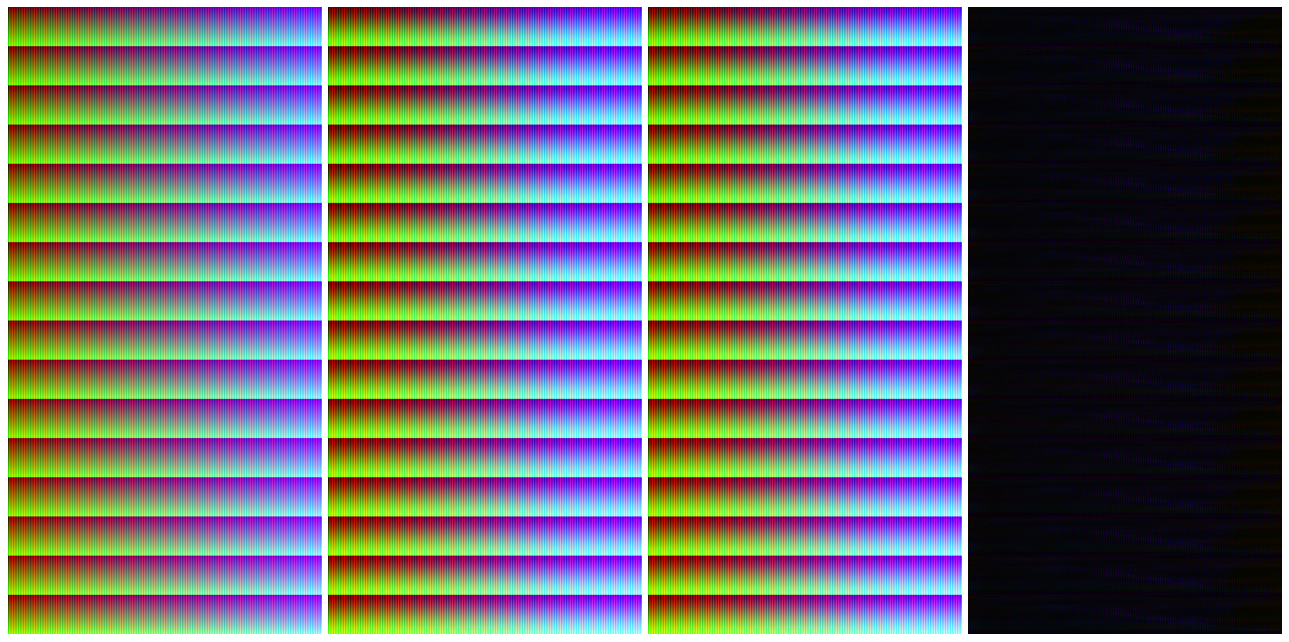

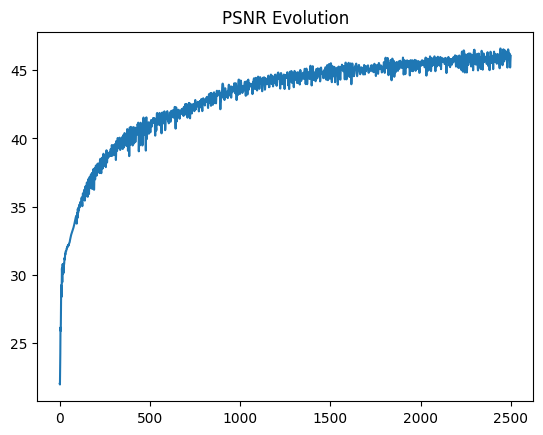

In [9]:
for exp_id, nilutconfig in enumerate(CONFIGS):
    
    torch.cuda.empty_cache()
    gc.collect()
    
    # Experiment setup
    real3dlut = LUTConfig.lut
    lut_size = LUTConfig.size
    total_steps = LUTConfig.steps
    steps_til_summary = LUTConfig.summary

    metrics  = defaultdict(list)
    inp_path = glob(os.path.join(LUTConfig.path, "Original")+'*')[0]
    out_path = glob(os.path.join(LUTConfig.path, real3dlut)+'*')[0]

    # Define the dataloader
    lut_images = LUTFitting(inp_path, out_path)
    dataloader = DataLoader(lut_images, batch_size=1, pin_memory=True, num_workers=0)
    
    # Define the model
    lut_model = NILUT(in_features=3, out_features=3, hidden_features=nilutconfig[0], hidden_layers=nilutconfig[1])
    lut_model.cuda()
    optim = torch.optim.Adam(lr=LUTConfig.lr, params=lut_model.parameters())
    
    # Load in memory the input and target hald images
    model_input_cpu, ground_truth_cpu = next(iter(dataloader))
    img_size = lut_images.shape
    model_input, ground_truth = model_input_cpu.cuda(), ground_truth_cpu.cuda()

    lut_model.train()
    start_timer()
    
    # Training loop
    for step in range(total_steps):
        
        # with torch.cuda.amp.autocast(dtype=torch.float16, enabled=use_amp):
        with torch.cuda.amp.autocast():
            model_output, _ = lut_model(model_input)
            # loss = torch.mean((model_output - ground_truth)**2)
            loss = torch.mean(torch.abs(model_output - ground_truth)) # more stable than L2
            _psnr = pt_psnr(ground_truth,model_output).item()
        
        metrics['mse'].append(loss.item())
        metrics['psnr'].append(_psnr)
        
        if ((step % steps_til_summary) == 0) or (step == total_steps-1):
            
            display.clear_output()
            
            original_inp = model_input_cpu.view(img_size[0],img_size[1],3).numpy().astype(np.float32)
            np_out       = model_output.cpu().view(img_size[0],img_size[1],3).detach().numpy().astype(np.float32)
            np_gt        = ground_truth.cpu().view(img_size[0],img_size[1],3).detach().numpy().astype(np.float32)
            np_diff      = np.abs(np_gt - np_out)
            
            psnr = np_psnr(np_gt, np_out)
            deltae = deltae_dist(np_gt, np_out)
            
            print(f"Step {step}, Total loss {loss}, PSNR={psnr}, DeltaE={deltae} --- min error {np.min(np_diff)}, max error {np.max(np_diff)}")
            print("Input / Ours NILUT / Real 3D LUT / Error Map")
            metrics['l2_lab'].append(deltae)
            
            plot_all([original_inp, np_out, np_gt, np_diff*10], figsize=(16,8))

            plt.plot(metrics['psnr'])
            plt.title("PSNR Evolution")
            plt.show()

            save_rgb(original_inp, f"results/exp_{exp_id}_{lut_size}_{real3dlut}_inp.png")
            save_rgb(np_out,       f"results/exp_{exp_id}_{lut_size}_{real3dlut}_out.png")
            save_rgb(np_gt ,       f"results/exp_{exp_id}_{lut_size}_{real3dlut}_gt.png")
        
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        optim.zero_grad()
    
    torch.save(lut_model.state_dict(), f"results/exp_{exp_id}_{lut_size}_{real3dlut}_nilut.pt")
    checkpoint = {"model": lut_model.state_dict(),
                  "optimizer": optim.state_dict(),
                  "scaler": scaler.state_dict()}
    torch.save(checkpoint, f"results/exp_{exp_id}_{lut_size}_{real3dlut}_ckpt.pt")
    
    with open(f'results/{lut_size}_{real3dlut}_history.pkl', 'wb') as handle:
        pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    clean_mem()

In less than 2 minutes the NILUT can reproduce the behaviour of the 3D LUT and the RGB space transformation.

The mapping is very accurate and can be improved by training longer. NOTE that training becomes more unestable with large number of iterations, LR decay might help with that.

In [10]:
!du -sh "results/exp_{exp_id}_{lut_size}_{real3dlut}_nilut.pt"

136K	results/exp_0_16M_LUT01_nilut.pt


# Evaluation on MIT5K Dataset

After the model fits the 3D LUT using the **hald** images, we can evaluate it on unseen images.

The model applies the 3D LUT style and enhances the images properly! Remember that the model never saw natural images like these ones.

Original dataset from "Learning Photographic Global Tonal Adjustment with a Database of Input / Output Image Pairs", CVPR 2011
https://people.csail.mit.edu/vladb/photoadjust/db_imageadjust.pdf

> NOTE: We just process a few images to make this tutorial light :) 

In [11]:
clean_mem()

lut_model.eval()
            
psnrs_5k_100 = []
originals = sorted([x for x in glob(f'dataset/adobe5k-100images/*') if '_LUT' not in x])
enhanced  = sorted(glob(f'dataset/adobe5k-100images/*_{real3dlut}.png'))

print ("Total images", len(originals), "evaluating on 3D LUT", real3dlut)
assert len(originals) == len(enhanced)

mit5k_data = MIT5KData(originals, enhanced)
mit5k_dl   = DataLoader(mit5k_data, batch_size=1, pin_memory=True, drop_last=True, num_workers=0)

Total images 100 evaluating on 3D LUT LUT01


  0%|          | 0/100 [00:00<?, ?it/s]

Input / Ours NILUT / Real 3D LUT -- res (2000, 3008, 3)


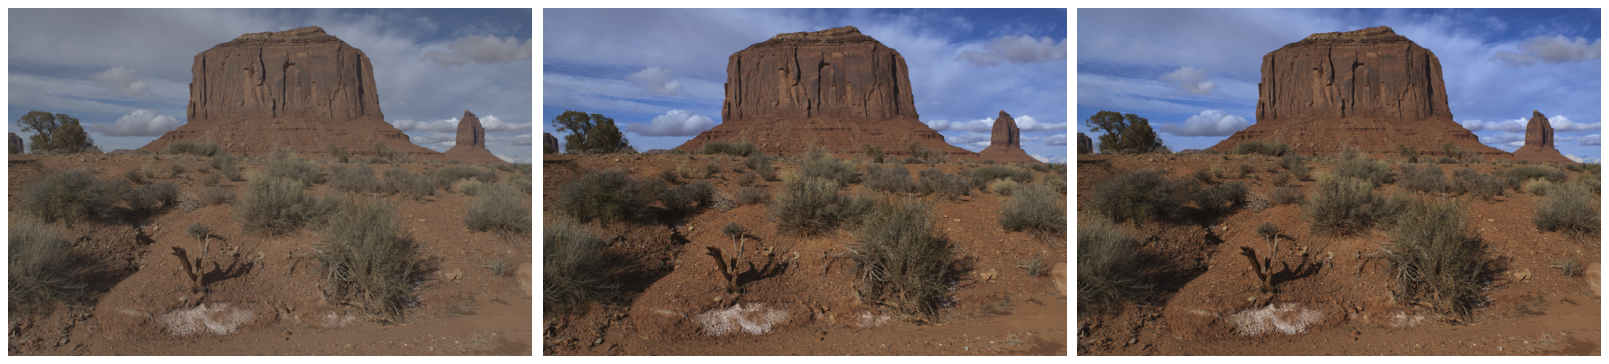

 10%|█         | 10/100 [01:26<14:04,  9.38s/it]

Input / Ours NILUT / Real 3D LUT -- res (3008, 2000, 3)


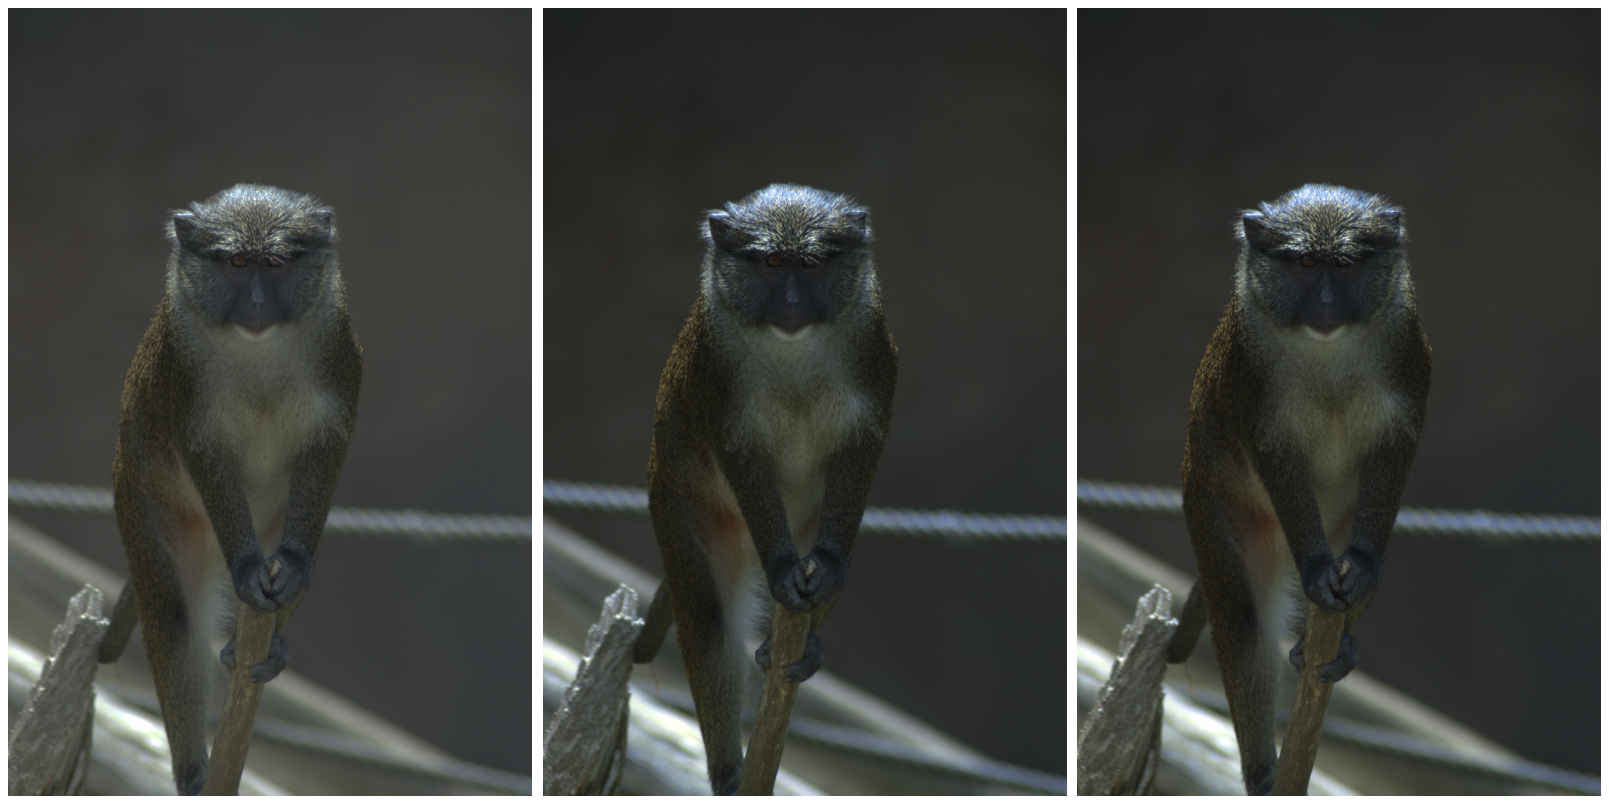

 19%|█▉        | 19/100 [02:37<11:12,  8.30s/it]

mean psnr 41.649487533364926 mean deltae 1.7956513462825465


In [13]:
cnt=0
for sample_img, ori_np, enh_np in tqdm(mit5k_dl):

    dummy_rgb = sample_img.to(device)
    dummy_rgb = dummy_rgb.half()
    
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            lut_out, _ = lut_model(dummy_rgb)
        
    ori_np  = ori_np.squeeze(0).numpy().astype(np.float32)
    enh_np  = enh_np.squeeze(0).numpy().astype(np.float32)
    lut_out = lut_out.cpu().view(ori_np.shape[0],ori_np.shape[1],3).detach().numpy().astype(np.float32)
    
    _psnr   = np_psnr(enh_np, lut_out)
    psnrs_5k_100.append(_psnr)
    metrics['psnrs_mit5k_100'].append(_psnr)

    deltae = deltae_dist(enh_np, lut_out)
    metrics['deltae_mit5k_100'].append(deltae)

    if (cnt % 10 == 0):
        print(f"Input / Ours NILUT / Real 3D LUT -- res {ori_np.shape}")
        plot_all([ori_np, lut_out, enh_np])
    
    del deltae, _psnr, ori_np, enh_np, lut_out, dummy_rgb
    clean_mem()
    cnt+=1

    # We just process the first 20 images to keep this tutorial notebook light :)
    if cnt >= 20: break
    
    
print ('mean psnr', np.mean(psnrs_5k_100), 'mean deltae', np.mean(metrics['deltae_mit5k_100']))

Hope you like it 🤗 If you find this interesting/insightful/inspirational or you use it, do not forget to acknowledge our work:

```
@article{conde2023nilut,
  title={NILUT: Conditional Neural Implicit 3D Lookup Tables for Image Enhancement},
  author={Conde, Marcos V and Vazquez-Corral, Javier and Brown, Michael S and Timofte, Radu},
  journal={arXiv preprint arXiv:2306.11920},
  year={2023}
}
```